In [1]:
%matplotlib inline

user-defined LaTeX commands
$\newcommand{\Er}{\mathcal{E}}$
$\newcommand{\Xset}{\mathcal{X}}$
$\newcommand{\Yset}{\mathcal{Y}}$
$\newcommand{\L}{\mathcal{L}}$
$\newcommand{\l}{\mathcal{l}}$
$\newcommand{\pr}{\mathbb{P}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\D}{\mathbb{D}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\I}{\mathbf{I}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\S}{\mathbf{S}}$
$\newcommand{\e}{\mathbf{e}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\R}{\mathbf{R}}$
$\newcommand{\v}{\mathbf{v}}$
$\newcommand{\phivec}{\boldsymbol{\phi}}$
$\newcommand{\sign}{\mathrm{sign}}$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from math import *

In [4]:
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import fmin

In [5]:
from ggplot import *
from matplotlib import colors as clrs
from matplotlib.colors import ListedColormap

In [6]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.stats import laplace

In [8]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    n_class = len(np.unique(y))
    colors = list(clrs.cnames.keys())[:n_class]
    
    cmap = ListedColormap(colors[:n_class])
    # decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.xlim(xx2.min(), xx2.max())
    # plot samples
    X_test, y_test = X[test_idx,:], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), label=cl)
    # test samples highlight
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidth=1, s=55, label='test set')

### Unconstrained Optimization
* Let $\mathcal{E}(\mathbf{w})$ be continuously differentiable cost function. 
Goal: find optimal solution $\mathbf{w}^*$, that satisfies the condition: $\mathcal{E}(\mathbf{w}^*)\leq \mathcal{E}(\mathbf{w})$, $\forall \mathbf{w}$. 
* We need to solve equation: $\nabla \mathcal{E}(\mathbf{w})=0$, where $\nabla \mathcal{E}(\mathbf{w})$ is gradient vector:
$$\nabla\mathcal{E}(\mathbf{w})=\left(\frac{\partial \mathcal{E}}{\partial w_1},\ldots,\frac{\partial \mathcal{E}}{\partial w_m}\right)^T$$
* Unconstrained optimization consists in finding the sequence of $\mathbf{w}(n)$, such that 
$$\mathcal{E}(\mathbf{w}(n+1))<\mathcal{E}(\mathbf{w}(n))$$

### Method of Steepest Descent
* Let's denote $\nabla\mathcal{E}(\mathbf{w})=g$, then method is described by equation:
$\mathbf{w}(n+1)=\mathbf{w}(n)-\eta g(n)$, where $\eta$ - is a learning rate parameter.

* In other words: $\Delta\w(n)=\w(n+1)-\w(n)=-\eta g(n)$

* From the first-order Taylor expansion we get:
$$\Er(\w(n+1))\approx \Er(\w(n))+g^T(n)\Delta\w(n)=\Er(\w(n))-\eta\|g(n)\|^2,$$ which means, that $\Er(\w(n+1))<\Er(\w(n))$

**One special example**
* Consider model $y=\w^T\x+\varepsilon=(b,w_1,w_2)^T\cdot(1,x_1,x_2)$, where $\varepsilon \sim N(0,\sigma^2)$.
* Let $w_1=w_2=0$, then model equation takes form $y=b+\varepsilon$
* Consider log-likelihood $$\log\L(\x)=-\frac{1}{2}(\x-\mu)^T\mathbf{\Sigma}^{-1}(\x-\mu)-\frac{1}{2}\log \det(\mathbf{\Sigma})-\frac{m}{2}\log(2\pi),$$
let's take the cost function $$\Er(\x)=\frac{1}{2}(\x-\mu)^T\mathbf{\Sigma}^{-1}(\x-\mu),$$
then $$g(\x)=(\x-\mu)^T\mathbf{\Sigma}^{-1}$$

In [9]:
class GradientDescent(object):
    
    def __init__(self, mean = [1,2], cov = [[2,.5],[.5,1]]):
        self.mean_ = mean
        self.cov_ = cov
    
    def cost(self, w):
        error = self.mean_ - w
        return np.dot(np.dot(error, np.linalg.inv(self.cov_)),error)/2.0
    
    def gradient(self, w):
        return -np.dot(self.mean_ - w, np.linalg.inv(self.cov_))
    
    def fit(self, w, eta = 0.01, n_iter = 10):
        self.eta_ = eta
        self.n_iter_ = n_iter
        self.w_ = []
        self.errors_ = np.zeros(self.n_iter_)
        self.w_.append(list(w))
        self.errors_[0] = self.cost(w)
        for i in range(1, self.n_iter_):
            self.errors_[i] = self.cost(w)
            w -= self.eta_*self.gradient(w)
            self.w_.append(list(w))
        self.w_ = np.array(self.w_)
        return self
    
    def plot(self, delta=0.1, xmin=-2.0, xmax=5.0, ymin=-2.0, ymax=5.0):
        x, y = np.mgrid[xmin:xmax:delta, ymin:ymax:delta]
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x 
        pos[:, :, 1] = y
        rv = multivariate_normal(self.mean_, self.cov_)
        plt.contour(x, y, rv.pdf(pos))
        plt.plot(self.w_.T[0],self.w_.T[1])
        plt.show()

Taking small learning rate produces smooth approximation to optimal point and slows down the method.

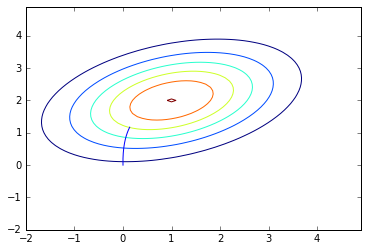

In [10]:
sd = GradientDescent()
w = np.array([0.0,0.0])
sd.fit(w, eta = 0.1, n_iter = 10)
sd.plot()

Taking large learning rate produces zig-zag approximation to optimal point and speeds-up the method.

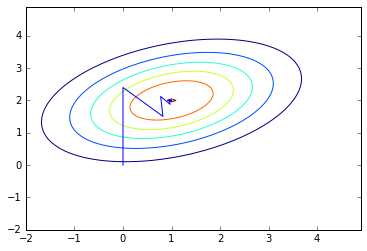

In [11]:
sd = GradientDescent()
w = np.array([0.0,0.0])
sd.fit(w, eta = 1.2, n_iter = 10)
sd.plot()

Taking too big learning rate can cause the **divergence issues**.

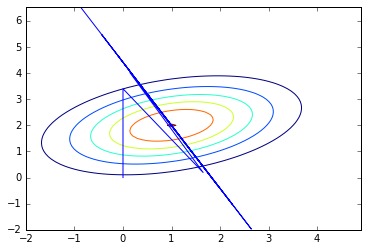

In [12]:
sd = GradientDescent()
w = np.array([0.0,0.0])
sd.fit(w, eta = 1.7, n_iter = 10)
sd.plot()

### Gauss-Newton Method
* Consider a model $y=\w^T\x$, let $e=e(\w)=y-\w^T\x$ be *errors*. 
* Define cost function as $$\Er(\w)=\frac{1}{2}\sum_{i=1}^ne^2(i)$$
* Linear approximation for error vector $e$ can be obtained via first-order Taylor expansion:
$$e(\w)\approx e(\w(n))+\J(n)(\w-\w(n)),$$ 
where $\J(n)=\left\{\frac{\partial e_i(\w(n))}{\partial \w_j}\right\}_{ij}$ - Jacobian matrix.

Jacobian matrix $$\J(n)=\left(\begin{array}{cccc}
\frac{\partial e(1)}{\partial w_1} & \frac{\partial e(1)}{\partial w_2} & \ldots & \frac{\partial e(1)}{\partial w_m}\\
\ldots & \ldots & \ldots & \ldots \\
\frac{\partial e(n)}{\partial w_1} & \frac{\partial e(n)}{\partial w_2} & \ldots & \frac{\partial e(n)}{\partial w_m}
\end{array}
\right)$$

* Define $\Delta(n)=\w-\w(n)$ and consider task of finding $\w$ minimizing sum of squares for r.h.s. 
of $e(\w)\approx e(\w(n))+\J(n)\Delta(n)$. 
* This $\w$ will be our next approximate solution $\w(n+1)$

Expand squared errors expression: 
$$\frac{1}{2}\|e(\w(n))+\J(n)\Delta(n)\|^2
=\frac{1}{2}\|e(\w(n))\|^2+e^T(\w(n))\J(n)\Delta(n) +\frac{1}{2}\Delta^T(n)\J^T(n)\J(n)\Delta(n)$$

Differentiate with respect to $\w$, set result equal to zero:
$$\J^T(n)e(\w(n))+\J^T(n)\J(n)\Delta(n)=0,$$
which leads us to
$$\w=\w(n)-\left( \J^T(n)\J(n) \right)^{-1}\J^T(n)e(\w(n))$$

Finally get Gauss-Newton method equation $$\w(n+1)=\w(n)-\left( \J^T(n)\J(n) \right)^{-1}\J^T(n)e(\w(n))$$

* Possible problem: singular matrix $\J^T(n)\J(n)$, to ensure this one can add regularization term:
$\J^T(n)\J(n) + \delta \I$ to make it positive definite $\forall n$
* Cost function: $$\Er(\w)=\frac{1}{2}\left\{ \sum_{i=1}^ne^2(i) +\delta\|\w-\w(n)\|^2 \right\}$$

**Special example: non-linear case**
* Non-linear case: $e_i(\w)=y_i-f(\x_i,\w)$, then Gauus-Newton algorithm can represented in the form
$$\w(n+1)=\w(n)+(\J_f^T\J_f)^{-1}\J_f^Te(\w(n)$$
* If, for example, we have to ''guess'' mean value vector $\w$ of bivariate normal distribution, picking up points $\x(i)$ and measuring log-likelihood values $y_i$
* Consider log-likelihood $$\log\L(\x)=-\frac{1}{2}(\x-\mu)^T\mathbf{\Sigma}^{-1}(\x-\mu)-\frac{1}{2}\log \det(\mathbf{\Sigma})-\frac{m}{2}\log(2\pi),$$ 
let's take the cost function $$\Er(\x)=\frac{1}{2}(\x-\mu)^T\mathbf{\Sigma}^{-1}(\x-\mu),$$
then $$g(\x)=(\x-\mu)^T\mathbf{\Sigma}^{-1}$$

In [13]:
def MAP(X, y, alpha=0.0):
    m = X.shape[1]
    I = np.identity(m)
    Rxx = np.dot(X.T, X)
    Ryx = np.dot(X.T, y)
    if alpha == 0.0:
        return np.dot(np.linalg.inv(Rxx), Ryx)
    elif alpha > 0.0:
        return np.dot(np.linalg.inv(Rxx + alpha * I), Ryx)

In [14]:
class GaussNewton(object):
    
    def __init__(self, mean = [3,3], cov = [[2,.5],[.5,1]]):
        self.mean_ = mean
        self.cov_ = cov
        self.w_ = []
        self.errors_ = []
    
    def cost(self, error):
        e = []
        for er in error:
            e.append(np.dot(np.dot(er, np.linalg.inv(self.cov_)),er)/2.0)
        return np.array(e)
    
    def jacobian(self, error):
        return np.dot(error, np.linalg.inv(self.cov_))
    
    def fit(self, X, delta = 0.0):
        self.X_ = X
        self.n_samples_ = X.shape[0]
        self.delta_ = delta
        w = np.array([0.0,0.0])
        for i in range(1,self.n_samples_):
            X_i = X[0:i+1,]
            error = (X_i + w - self.mean_)
            e = self.cost(error)
            J = self.jacobian(error)
            w -= MAP(J, e, self.delta_)
            self.w_.append(list(w))
        self.w_ = np.array(self.w_)
        return self
    
    def plot(self, delta=0.1, xmin=-2, xmax=5.0, ymin=-2.0, ymax=5.0):
        x, y = np.mgrid[xmin:xmax:delta, ymin:ymax:delta]
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x 
        pos[:, :, 1] = y
        rv = multivariate_normal(self.mean_, self.cov_)
        plt.contour(x, y, rv.pdf(pos))
        plt.plot(self.w_.T[0],self.w_.T[1])
        plt.scatter(self.w_.T[0],self.w_.T[1],color='blue')
        plt.scatter(self.X_.T[0],self.X_.T[1], color='red')
        plt.show()

Consider the case of small variance of input points: we obtain smooth path.

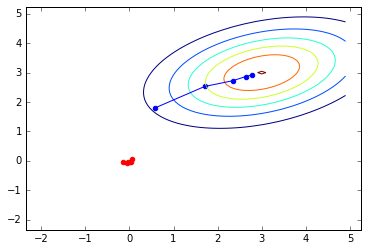

In [15]:
gn = GaussNewton ()
n = 6
X = multivariate_normal.rvs(mean=[0, 0], cov=[[0.01, 0], [0, 0.01]], size=n)
gn.fit(X, delta=0.1)
gn.plot ()

Consider the case of large variance of input points: we obtain zig-zag path.

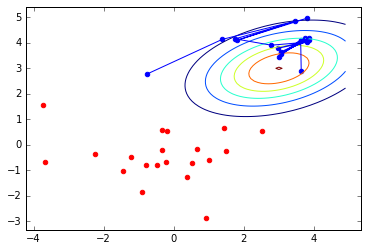

In [16]:
gn = GaussNewton ()
n = 20
X = multivariate_normal.rvs(mean=[0, 0], cov=[[1.5, 0], [0, 1.5]], size=n)
gn.fit(X, delta=0.1)
gn.plot ()

### Wiener filter
Consider model equation $\e(n) = \y(n)-\X(n)\w(n)$, where $\y(n)=(y(1),\ldots,y(n))^T$ - 
vector of desired outputs, $\X(n)=(\x(1),\ldots,\x(n))^T$ - matrix with history of observations.

Gradient matrix for errors: $\nabla \e(n)=-\X^T(n)$, then Jacobian is $\J(n)=-\X(n)$

From Gauss-Newton algorithm we get 
$$\w(n+1)=\w(n)+\left(\X^T(n)\X(n)\right)^{-1}\X^T(n)\left(\y(n)-\X(n)\w(n)\right)=\left(\X^T(n)\X(n)\right)^{-1}\X^T(n)\y(n)=\X^+(n)\y(n),$$ 
where $\X^+=\left(\X^T\X\right)^{-1}\X^T$ - matrix pseudo-inverse

In [17]:
def MAP(X, y, alpha = 0.0):
    m = X.shape[1]
    I = np.identity (m)
    Rxx = np.dot (X.T, X)
    Ryx = np.dot (X.T, y)
    if alpha == 0.0:
        return np.dot (np.linalg.inv (Rxx), Ryx)
    elif alpha > 0.0:
        return np.dot (np.linalg.inv (Rxx + alpha * I), Ryx)

In [18]:
class WienerFilter(object):
    def __init__(self, alpha = 0.0):
        self.alpha_ = alpha
        
    def fit(self, X, y, alpha = None):
        if alpha == None:
            alpha = self.alpha_
        self.n_samples_ = X.shape[0]
        self.w_ = []
        for i in range(1,self.n_samples_):
            X_i = X[0:i+1,]
            y_i = y[0:i+1]
            self.w_.append(list(MAP(X_i, y_i, alpha)))
        self.w_ = np.array(self.w_)
        return self
    
    def predict(self, X, epoch = -1):
        self.y_ = np.dot(X, self.w_[epoch])
        return self.y_
    
    def score(self, y):
        errors = (y - self.y_)**2/2.0
        return np.sqrt(np.sum(errors))/len(y)
    
    def plot(self, target_values=None):
        plt.plot(self.w_.T[0],self.w_.T[1])
        plt.scatter(self.w_.T[0],self.w_.T[1],color='blue',alpha=0.5)
        if target_values != None:
            plt.scatter(target_values[0],target_values[1],color='red')
        plt.show()

In [42]:
class WienerFilter(object):
    def __init__(self, alpha = 0.0):
        self.alpha_ = alpha
        
    def fit(self, X, y, alpha = None):
        if alpha == None:
            alpha = self.alpha_
        self.X_ = X
        self.y_ = y
        self.n_samples_ = X.shape[0]
        self.w_ = []
        for i in range(1,self.n_samples_):
            X_i = X[0:i+1,]
            y_i = y[0:i+1]
            self.w_.append(list(MAP(X_i, y_i, alpha)))
        self.w_ = np.array(self.w_)
        return self
    
    def predict(self, X, epoch = -1):
        self.y_pred_ = np.dot(X, self.w_[epoch])
        return self.y_pred_
    
    def score(self, y):
        errors = (y - self.y_)**2/2.0
        return np.sqrt(np.sum(errors))/len(y)
    
    def plot(self, target_values=None, choice = 'dynamics'):
        if choice == 'dynamics':
            pnt = pd.DataFrame(dict (x = self.w_.T[0], y = self.w_.T[1]))
            p = ggplot(aes(x='x', y='y'), data=pnt) + geom_path(color='blue') \
                + geom_point(color='blue',alpha=0.1)
            
            if target_values != None:
                tgt = pd.DataFrame(dict(x=[target_values[0]], y= [target_values[1]]))
                p += geom_point(aes(x='x', y='y'), data=tgt,size=40, color='red')
        elif choice == 'estimates':
            y_pred = self.predict(self.X_)
            dat = pd.DataFrame(dict(x=self.X_.T[1],y=self.y_))
            p = ggplot(aes(x='x',y='y'), data=dat)+geom_point(color='blue',alpha=0.5)
            line = pd.DataFrame(dict(x=self.X_.T[1],y=y_pred))
            p += geom_line(aes(x='x',y='y'),data=line,color='red')
        return p

Consider linear model regression example
$\y=\w^T\x+\varepsilon=(a,b)^T(1,x)+\varepsilon$, where $\varepsilon\sim N(0,\sigma^2)$

Plot estimate's path

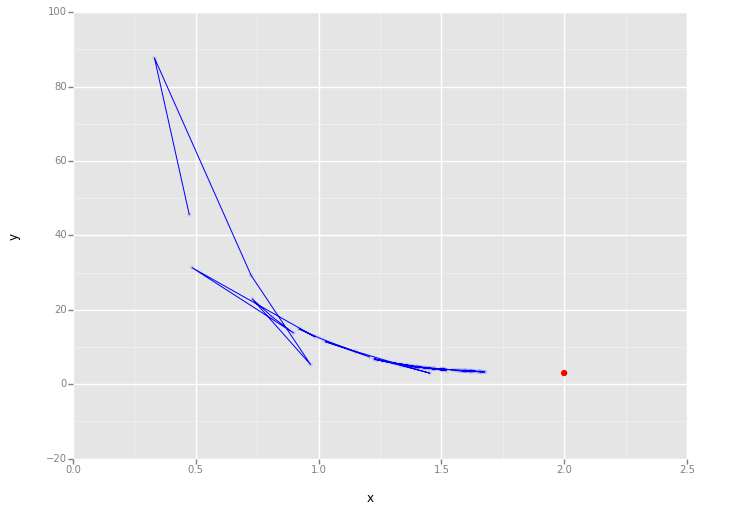

<ggplot: (287803989)>

In [43]:
n = 100
a = 2.0
b = 3.0
x = np.linspace (0, 1.0, n)
e = norm.rvs (size = n)
y = b * x + a + e
I = np.array ([1] * n)
X = np.vstack ((I, x)).T
wf = WienerFilter()
wf.fit(X, y, alpha=0.0)
wf.plot([a, b])

Plot fitted line

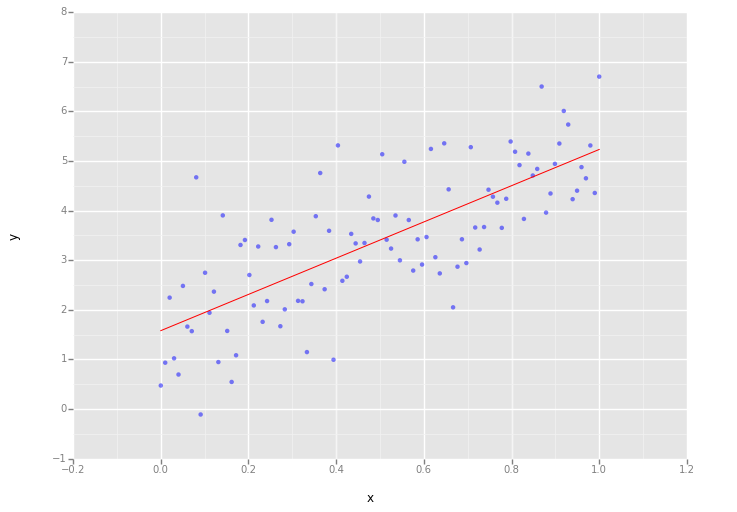

<ggplot: (287805139)>

In [44]:
wf.plot(choice='estimates')

Let's take second-order polynomial model
$\y=\w^T\x+\varepsilon=(a,b,c)^T(1,x,x^2)+\varepsilon$, where $\varepsilon\sim N(0,\sigma^2)$

Plot estimate's path

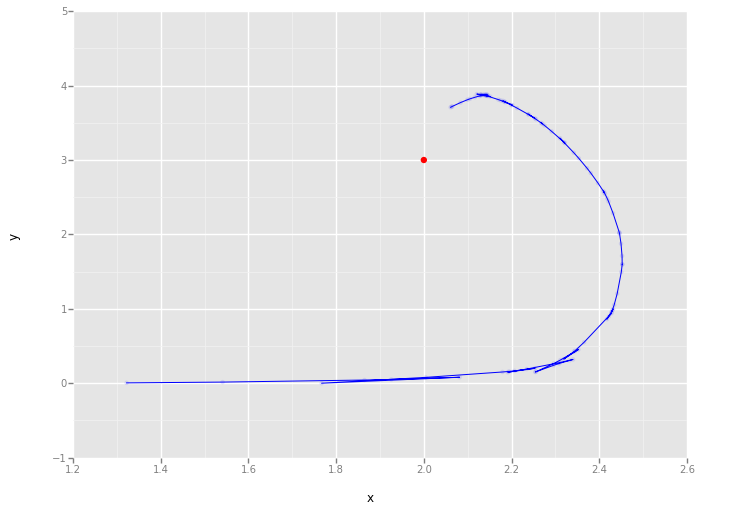

<ggplot: (289385024)>

In [45]:
n = 100
a = 2.0
b = 3.0
c = 5
x = np.linspace (0, 1.0, n)
e = norm.rvs (size = n)
y = c * x ** 2 + b * x + a + e
I = np.array ([1] * n)
X = np.vstack ((I, x, np.power (x, 2))).T
wf = WienerFilter()
wf.fit(X, y, alpha=1.1)
wf.plot([a, b])

Plot fitted line

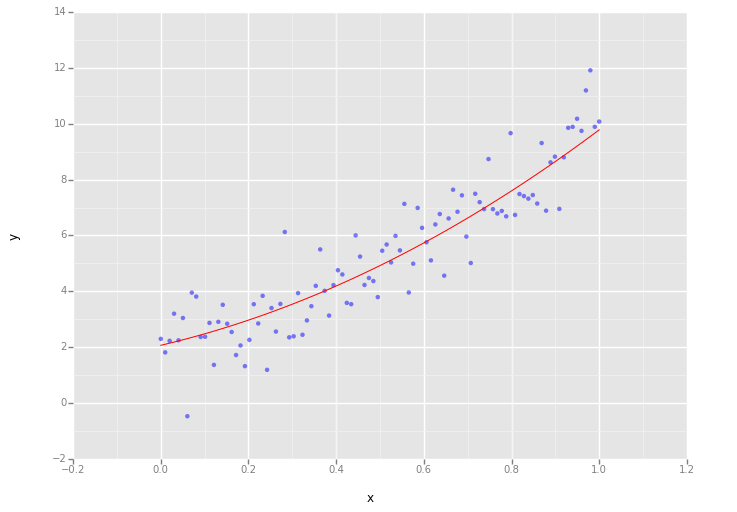

<ggplot: (-9223372036565385563)>

In [46]:
wf.plot(choice='estimates')

Consider third-order polynomial model
$\y=\w^T\x+\varepsilon=(a,b,c,d)^T(1,x,x^2,x^3)+\varepsilon$, where $\varepsilon\sim N(0,\sigma^2)$

Plot estimate's path

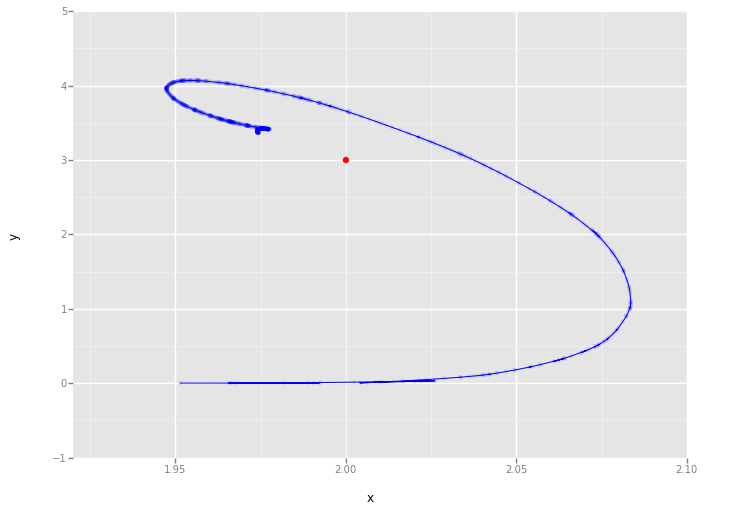

<ggplot: (294812010)>

In [47]:
n = 1000
a = 2.0
b = 3.0
c = 5.0
d = 2.0
x = np.linspace(0.0, 1.0, n)
e = norm(scale=0.1).rvs (size = n)
y = d * x ** 3 + c * x ** 2 + b * x + a + e
I = np.array ([1] * n)
X = np.vstack((I, x, np.power(x, 2), np.power(x, 3))).T
wf = WienerFilter()
wf.fit(X, y, alpha=.1)
wf.plot([a, b])

Plot fitted line

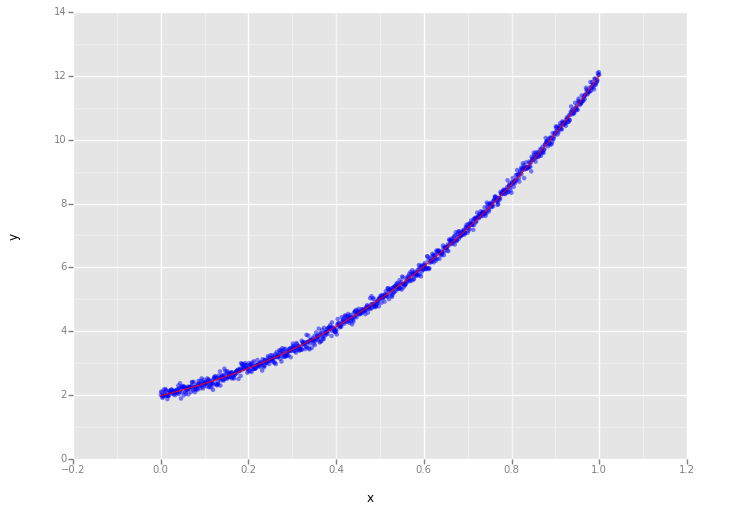

<ggplot: (294815843)>

In [48]:
wf.plot(choice='estimates')